<a href="https://colab.research.google.com/github/bevil56/age-detection/blob/master/Age_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing the [Kaggle API](https://github.com/Kaggle/kaggle-api) in Colab

In [6]:
!pip install kaggle

Authenticating with Kaggle using kaggle.json
Navigate to https://www.kaggle.com. Then go to the Account tab of your user profile and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.


In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


## Downloading a dataset

In [8]:
!kaggle datasets download "jangedoo/utkface-new"

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 91% 303M/331M [00:03<00:00, 35.9MB/s]
100% 331M/331M [00:03<00:00, 94.9MB/s]


In [9]:
!unzip utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

## Import Modules


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

##Load the Dataset


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
BASE_DIR = '/content/utkface_new/UTKFace'


In [13]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [14]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/utkface_new/UTKFace/2_0_3_20161220144...,2,0
1,/content/utkface_new/UTKFace/31_0_1_2017011718...,31,0
2,/content/utkface_new/UTKFace/25_1_0_2017010500...,25,1
3,/content/utkface_new/UTKFace/1_0_3_20161220222...,1,0
4,/content/utkface_new/UTKFace/22_0_1_2017010223...,22,0


##Exploratory Data Analysis


In [15]:
gender_dict = {0:'Male', 1:'Female'}

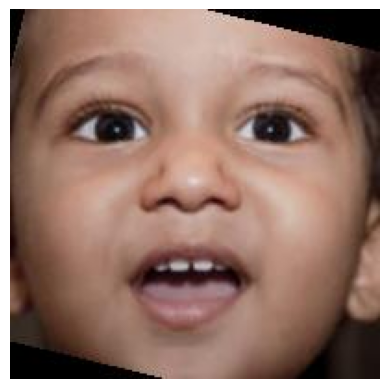

In [16]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

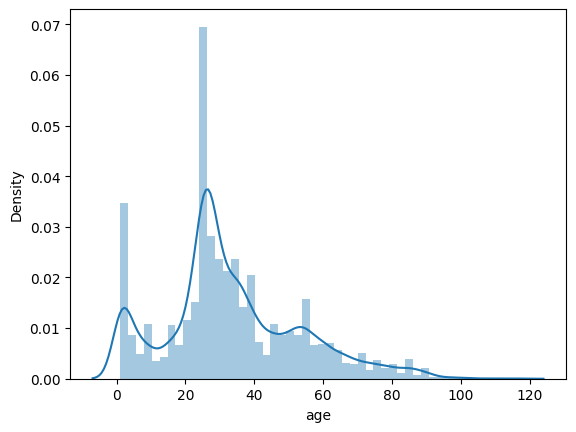

In [35]:
sns.distplot(df['age'])


<Axes: xlabel='gender'>

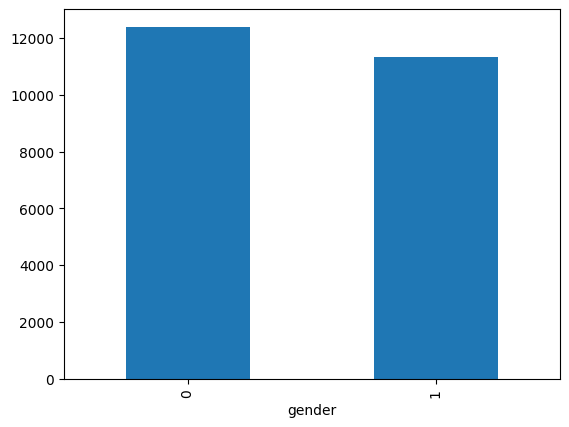

In [22]:
df['gender'].value_counts().plot(kind='bar')


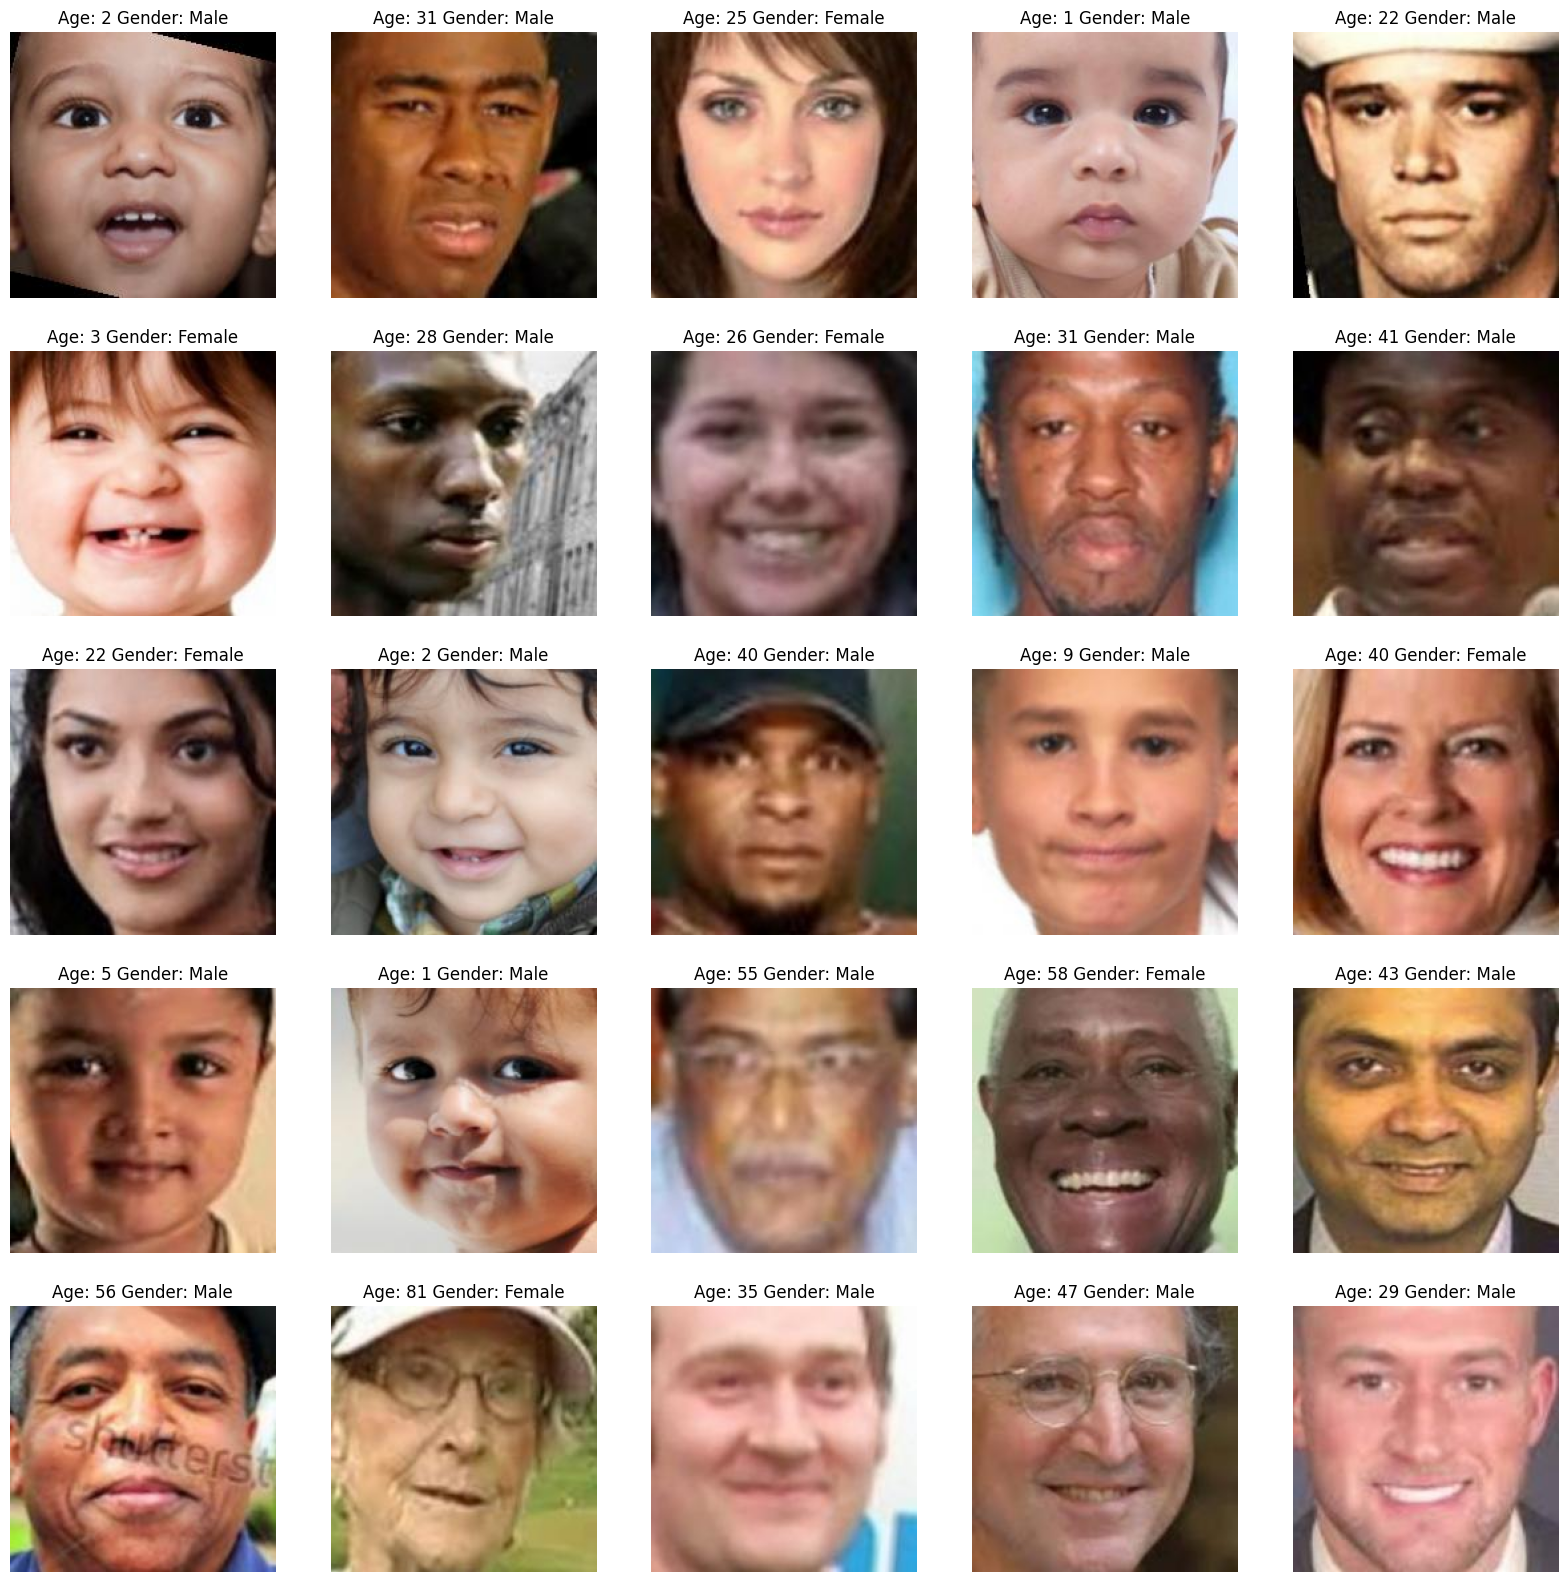

In [19]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

##Feature Extraction

In [23]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [24]:
X = extract_features(df['image'])


  0%|          | 0/23708 [00:00<?, ?it/s]

In [25]:
X.shape


(23708, 128, 128, 1)

In [26]:
# normalize the images
X = X/255.0

In [27]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [28]:
input_shape = (128, 128, 1)

Model Creation


In [29]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]']   

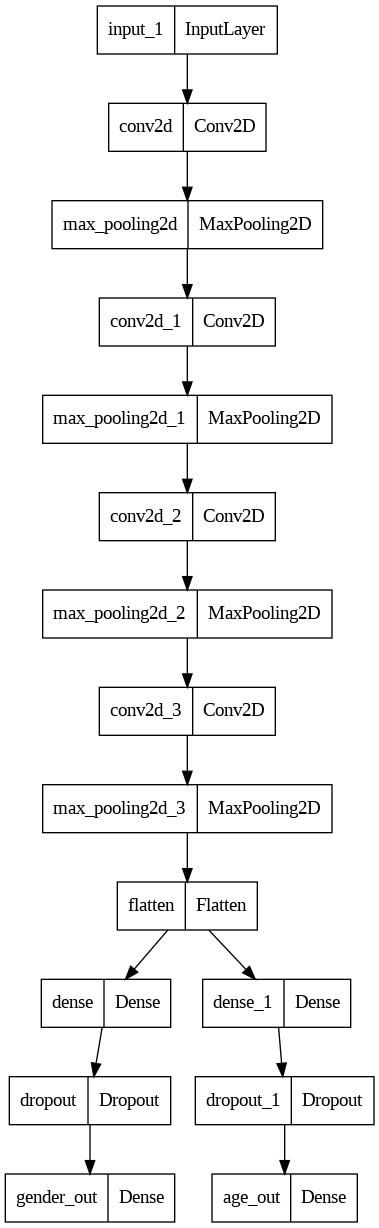

In [31]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [32]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)


Epoch 1/30
593/593 [==============================] - 23s 25ms/step - loss: 15.3843 - gender_out_loss: 0.6652 - age_out_loss: 14.7191 - gender_out_accuracy: 0.5781 - gender_out_mae: 0.4667 - age_out_accuracy: 0.0466 - age_out_mae: 14.7191 - val_loss: 11.9492 - val_gender_out_loss: 0.5440 - val_age_out_loss: 11.4052 - val_gender_out_accuracy: 0.7446 - val_gender_out_mae: 0.3907 - val_age_out_accuracy: 0.0437 - val_age_out_mae: 11.4052
Epoch 2/30
593/593 [==============================] - 13s 22ms/step - loss: 11.3205 - gender_out_loss: 0.4856 - age_out_loss: 10.8349 - gender_out_accuracy: 0.7645 - gender_out_mae: 0.3252 - age_out_accuracy: 0.0330 - age_out_mae: 10.8349 - val_loss: 9.7154 - val_gender_out_loss: 0.4084 - val_age_out_loss: 9.3071 - val_gender_out_accuracy: 0.8148 - val_gender_out_mae: 0.2813 - val_age_out_accuracy: 0.0192 - val_age_out_mae: 9.3071
Epoch 3/30
593/593 [==============================] - 13s 21ms/step - loss: 9.7372 - gender_out_loss: 0.4061 - age_out_loss: 9.

##Plot the Results


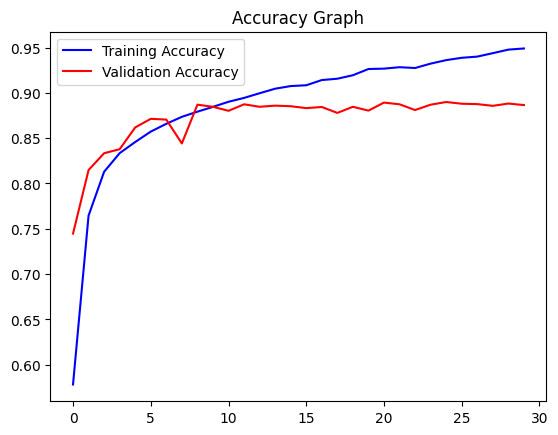

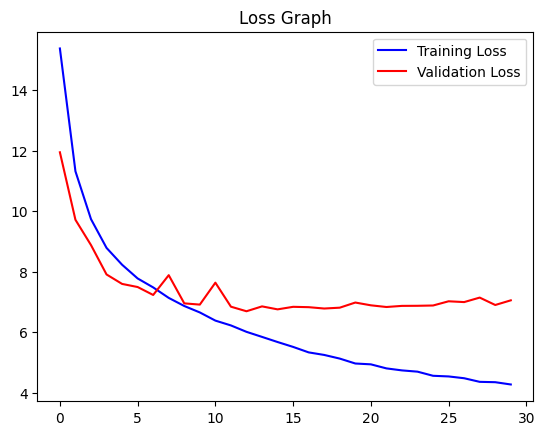

In [33]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
##Prediction with Test Data

Original Gender: Female Original Age: 40
1/1 [==============================] - 0s 345ms/step
Predicted Gender: Female Predicted Age: 38


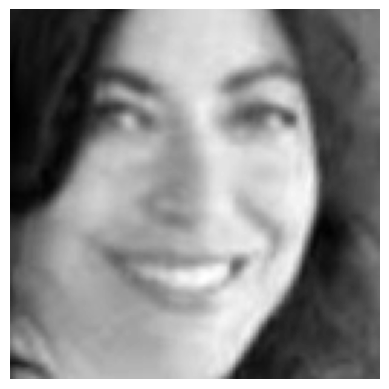

In [34]:
image_index = 56
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');